In [544]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.simdata_i3 import I3SimBatchHandlerTFRecord
from lib.geo import center_track_pos_and_time_based_on_data_batched_v
from lib.experimental_methods import get_clean_pulses_fn_v
from lib.network import get_network_eval_v_fn

from likelihood_mpe_padded_input import get_neg_c_triple_gamma_llh
from lib.geo import get_xyz_from_zenith_azimuth, __c
from dom_track_eval import get_eval_network_doms_and_track2 as get_eval_network_doms_and_track
import time

dtype = jnp.float32
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco/data/network',
                                       dtype=dtype)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=dtype)

# Create padded batches (with different seq length).
event_ids = ['1022', '10393', '10644', '10738', '11086', '11232', '13011',
       '13945', '14017', '14230', '15243', '16416', '16443', '1663',
       '1722', '17475', '18846', '19455', '20027', '21113', '21663',
       '22232', '22510', '22617', '23574', '23638', '23862', '24530',
       '24726', '25181', '25596', '25632', '27063', '27188', '27285',
       '28188', '28400', '29040', '29707', '3062', '31920', '31989',
       '32781', '32839', '33119', '33656', '34506', '35349', '37086',
       '37263', '37448', '37786', '37811', '39166', '39962', '40023',
       '41381', '41586', '42566', '42568', '42677', '43153', '43483',
       '4397', '44081', '48309', '48448', '48632', '49067', '50832',
       '51687', '51956', '54374', '55301', '55526', '55533', '56041',
       '5620', '56741', '56774', '57174', '57394', '57723', '59010',
       '59029', '59089', '59099', '59228', '62274', '62512', '63373',
       '65472', '6586', '8', '8604', '8674', '8840', '9410', '9419',
       '9505']

ix = 0
print(event_ids[ix])
tfrecord = f"/home/storage2/hans/i3files/alerts/bfrv2/event_{event_ids[ix]}_N100_from_0_to_10_1st_pulse.tfrecord"



#tfrecord = "/home/storage2/hans/i3files/golden_muons/IC/NominalIce/MuMinus_150e3GeV_Horizontal_CloseToDOMs_Smooth_N100_from_0_to_10_1st_pulse.tfrecord"
#tfrecord = "/home/storage2/hans/i3files/golden_muons/IC/NominalIce/MuMinus_150e3GeV_Horizontal_CloseToDOMs_Stochastic_N100_from_0_to_10_1st_pulse.tfrecord"
# ridiculous pulse: 2063.8000043034554pe
# ridiculous pulse 97pe

#tfrecord = "/home/storage2/hans/i3files/golden_muons/IC/NominalIce/MuMinus_150e3GeV_Horizontal_FarFromDOMs_Stochastic_N100_from_0_to_10_1st_pulse.tfrecord"
#tfrecord = "/home/storage2/hans/i3files/golden_muons/IC/NominalIce/MuMinus_150e3GeV_Horizontal_FarFromDOMs_Smooth_N100_from_0_to_10_1st_pulse.tfrecord"
# ridiculous pulse: 2063.8000043034554pe
# ridiculous pulse 97pe

batch_maker = I3SimBatchHandlerTFRecord(tfrecord, batch_size=100)
batch_iter = batch_maker.get_batch_iterator()

# Until LLH has a noise-term, we need to remove crazy early noise pulses
clean_pulses_fn_v = get_clean_pulses_fn_v(eval_network_doms_and_track)

data, mctruth = batch_iter.next()
data = jnp.array(data.numpy())
mctruth = jnp.array(mctruth.numpy())
data_clean_padded = clean_pulses_fn_v(data, mctruth)

track_times = mctruth[:, 4]
track_positions = mctruth[:, 5:8]
track_srcs = mctruth[:,2:4]

1022


In [545]:
track_times_ = track_times.reshape((len(track_times), 1))

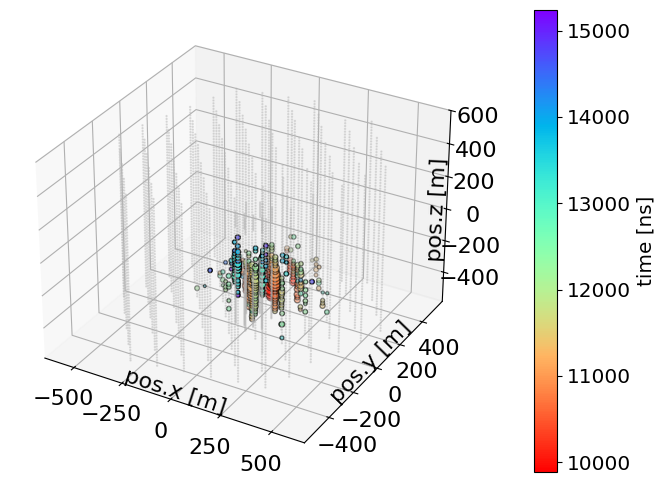

In [546]:
geo = pd.read_csv('/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')
pulses = data_clean_padded[0]
df = pd.DataFrame(data=pulses, columns = ["x", "y", "z", "time", "charge"])

def plot_event(df, geo=None):
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(projection='3d')
    ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
    ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
    ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)

    idx = df['charge'] > 0
    
    try:
        im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
    except:
        pass
    
    im = ax.scatter(df[idx]['x'], df[idx]['y'], df[idx]['z'], s=np.sqrt(df[idx]['charge']*100), c=df[idx]['time'], 
                    cmap='rainbow_r',  edgecolors='k', zorder=1000)
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
    cb = plt.colorbar(im, orientation="vertical", pad=0.1)
    cb.set_label(label='time [ns]', size='x-large')
    cb.ax.tick_params(labelsize='x-large')
        
    plt.show()

plot_event(df, geo)

In [547]:
hit_x = np.array(data_clean_padded[..., 0].flatten())
hit_y = np.array(data_clean_padded[..., 1].flatten())
hit_z = np.array(data_clean_padded[..., 2].flatten())
hit_t = np.array((data_clean_padded[..., 3]-track_times_).flatten())
hit_q = np.array(data_clean_padded[..., 4].flatten())

In [548]:
from collections import defaultdict
times_dict = defaultdict(list)
charges_dict = defaultdict(list)

for i in range(len(hit_x)):
    q = hit_q[i]
    if q < 1.e-3:
        continue

    if q > 1000:
        continue
        
    x = hit_x[i]
    y = hit_y[i]
    z = hit_z[i]
   
    t = hit_t[i]
    times_dict[(x,y,z)].append(t)
    charges_dict[(x,y,z)].append(q)

qtot_dict = dict()
for key, qs in charges_dict.items():
    qtot_dict[key]=sum(qs) / len(qs)

In [549]:
max_om = max(qtot_dict, key=charges_dict.get)

In [550]:
print(qtot_dict[max_om])

140.07603073872858


In [551]:
print(charges_dict[max_om])

[126.70000049471855, 121.52499994635582, 150.3999993801117, 130.99999976158142, 137.69999760389328, 133.24999922513962, 126.07499974966049, 131.8249996304512, 130.60000202059746, 160.0999995470047, 147.9749999642372, 183.10000050067902, 140.3499986231327, 136.5749996304512, 144.99999994039536, 125.50000213086605, 148.47499836981297, 115.59999895095825, 129.975002348423, 141.7750011086464, 137.12500077486038, 130.09999780356884, 142.549999833107, 154.32499988377094, 143.0499993264675, 124.77499857544899, 124.8000024408102, 119.24999947845936, 145.95000010728836, 133.95000061392784, 149.82500126957893, 124.94999934732914, 138.42500095069408, 139.10000032186508, 145.92500066757202, 160.69999940693378, 152.7000012099743, 156.07500004768372, 127.12499913573265, 146.32499995827675, 147.99999928474426, 143.80000174045563, 141.32499715685844, 125.62499970197678, 150.52500005066395, 141.55000242590904, 152.35000360012054, 150.92499908804893, 141.27500197291374, 120.8999996483326, 136.1249994635

In [552]:
print(times_dict[max_om])
print(np.min(times_dict[max_om]))
print(np.max(times_dict[max_om]))
print(np.std(times_dict[max_om]))

[3862.2852394489582, 3858.9769811222886, 3863.20253849831, 3863.002679209161, 3858.8476642020196, 3865.0633112968135, 3859.291702536808, 3859.1605158899256, 3865.7336687595052, 3862.4970517890215, 3857.35050605944, 3859.2967777356826, 3861.37910674016, 3863.9227243291116, 3862.632233514274, 3858.780730717819, 3864.1179662085488, 3864.018728181485, 3862.5533475177726, 3860.376618618331, 3861.4324728827996, 3858.8437942029923, 3859.0105759009384, 3860.8663159667776, 3858.5146430946006, 3861.8964620471124, 3860.887220222001, 3859.7839420648306, 3864.064314281326, 3858.713772432702, 3859.069283580242, 3861.418471476003, 3866.3761015701366, 3863.8653675262085, 3858.335163423557, 3860.630117436962, 3862.524331998946, 3862.508665892441, 3855.9344082949683, 3862.41523250693, 3858.7520206217123, 3855.5626173967394, 3861.320731425805, 3857.442704685309, 3863.103659400076, 3861.50197003629, 3863.9166243854143, 3859.3196220213704, 3864.310327554571, 3858.658092634112, 3864.0405990297477, 3858.6821

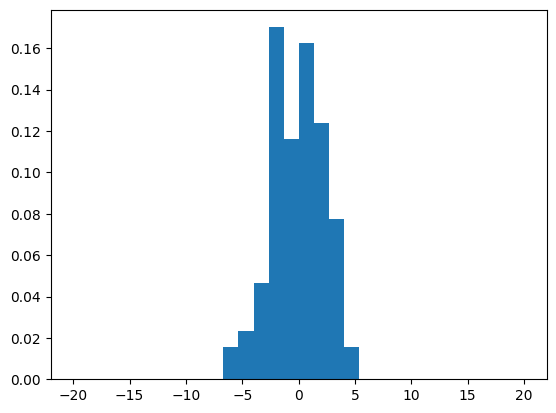

In [553]:
plt.hist(times_dict[max_om]-np.median(times_dict[max_om]), bins=np.linspace(-20, 20, 31), density=True)
plt.show()

In [554]:
positions_batch = []
for key in times_dict.keys():
    positions_batch.append(jnp.array(key).reshape((1,3)))

positions_batch = jnp.concatenate(positions_batch, axis=0)

In [555]:
logits, av, bv, geo_time = eval_network_doms_and_track(positions_batch, track_positions[0], track_srcs[0])
mix_probs = jax.nn.softmax(logits)

In [556]:
for i in range(len(positions_batch)):
    pos = tuple(np.array(positions_batch[i]))
    gt = geo_time[i]
    for j in range(len(times_dict[pos])):
        times_dict[pos][j] -= float(gt)

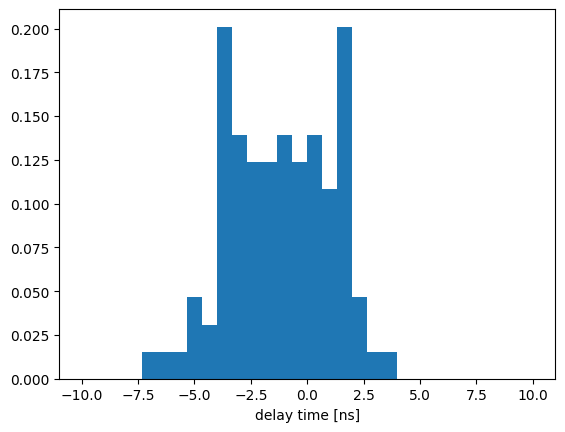

2.2951708670429913


In [557]:
plt.hist(times_dict[max_om], bins=np.linspace(-10, 10, 31), density=True)
plt.xlabel('delay time [ns]')
plt.show()

print(np.std(times_dict[max_om]))

In [558]:
print(times_dict[max_om])

[-0.15056116797313734, -3.4588194946427393, 0.7667378813785035, 0.5668785922298412, -3.588136414911787, 2.627510679882107, -3.1440980801235128, -3.2752847270057828, 3.2978681425738614, 0.06125117209012387, -5.085294557491579, -3.1390228812488203, -1.0566938767715328, 1.4869237121802144, 0.19643289734267455, -3.655069899112277, 1.6821655916173768, 1.5829275645537564, 0.11754690084126196, -2.059181998600252, -1.0033277341317444, -3.592006413939089, -3.425224715992954, -1.569484650153754, -3.921157522330759, -0.5393385698189377, -1.5485803949304682, -2.651858552100748, 1.6285136643946316, -3.7220281842292025, -3.3665170366894017, -1.0173291409282683, 3.9403009532052238, 1.4295669092771277, -4.100637193374496, -1.805683179969492, 0.08853138201448019, 0.07286527550968458, -6.501392321963067, -0.02056811000147718, -3.6837799952190835, -6.873183220192004, -1.1150691911261674, -4.99309593162252, 0.6678587831447658, -0.93383058064137, 1.4808237684828782, -3.1161785955609957, 1.87452693763953, -

In [559]:
from lib.geo import cherenkov_cylinder_coordinates_w_rho2_v as cherenkov_cylinder_coordinates_w_rho_v
from lib.geo import get_xyz_from_zenith_azimuth

In [560]:
track_dir_xyz = get_xyz_from_zenith_azimuth(track_srcs[0])

geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
            cherenkov_cylinder_coordinates_w_rho_v(positions_batch,
                                         track_positions[0],
                                         track_dir_xyz)

In [561]:
print(closest_approach_dist)

[159.0454249  124.77800179  90.56919705 ... 380.40302752 328.72073152
 253.90314068]


In [562]:
dom_i = None
for i in range(len(positions_batch)):
    if tuple(np.array(positions_batch[i]))==max_om:
        dom_i = i

In [563]:
dist = closest_approach_dist[dom_i]
print(dist)
print(closest_approach_z[dom_i])
print(closest_approach_rho[dom_i])

1.9848125342830414
-450.1161122810937
1.715215554625047


In [564]:
from lib.cgamma import c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


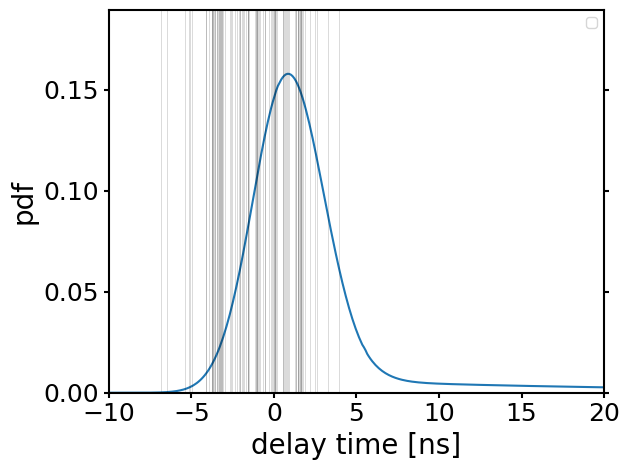

In [565]:
c_multi_gamma_prob_vx = jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0)

xvals = np.linspace(-10, 3000, 30000)

m = mix_probs[dom_i]
a = av[dom_i]
b = bv[dom_i]
yval = c_multi_gamma_prob_vx(xvals, m, a, b, 2.0, 0.1)
mode = (a[1]-1)/b[1]
fig, ax = plt.subplots()
plt.plot(xvals, yval)
    
plot_args = {'xlim':[-10, np.max([20, 10 * mode])],
                     'ylim':[0.0, 1.2 * np.amax(yval)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

for tx in times_dict[max_om]:
    plt.axvline(tx, alpha=0.2, color='black', lw=0.5)

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

1.9848125342830414
141.0
5.68278101568007


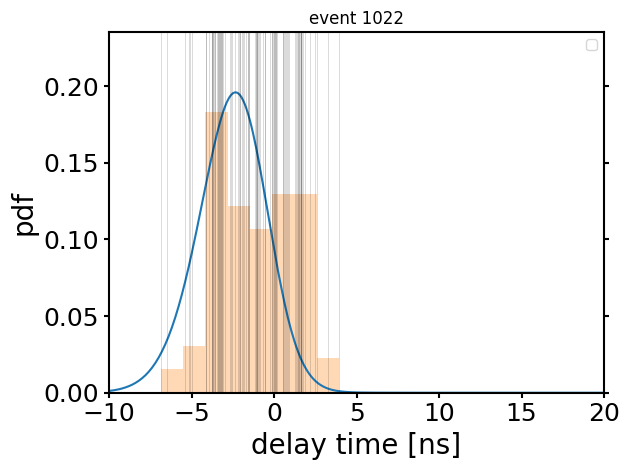

In [566]:
print(dist)
c_multi_gamma_sf_vx = jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0)

n_p = qtot_dict[tuple(np.array(positions_batch[dom_i]))]
n_p = np.round(n_p+0.5)
print(n_p)
#n_p = np.min([12.0, n_p])
#n_p = np.floor(np.min([np.exp(0.21*dist) / (1 + np.exp(-0.04*dist))+1.5, n_p]))
#n_p = np.floor(np.min([3.6*np.exp(0.23*dist), n_p]))
n_p = np.min([3.6*np.exp(0.23*dist), n_p])
print(n_p)

m = mix_probs[dom_i]
a = av[dom_i]
b = bv[dom_i]

probs = c_multi_gamma_prob_vx(xvals, m, a, b, 3.0, 0.1)
sfs = c_multi_gamma_sf_vx(xvals, m, a, b, 3.0)
yval = n_p * probs * jnp.power(sfs, n_p-1)

mode = (a[1]-1)/b[1]
fig, ax = plt.subplots()
plt.title(f"event {event_ids[ix]}")
plt.plot(xvals, yval)
    
plot_args = {'xlim':[-10, np.max([20, 5 * np.amax(tx)])],
                     'ylim':[0.0, 1.2 * np.amax(yval)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

for tx in times_dict[max_om]:
    plt.axvline(tx, alpha=0.2, color='black', lw=0.5)

plt.hist(times_dict[max_om], bins=np.linspace(np.min(times_dict[max_om]), np.max(times_dict[max_om]), 9), density=True, alpha=0.3)

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

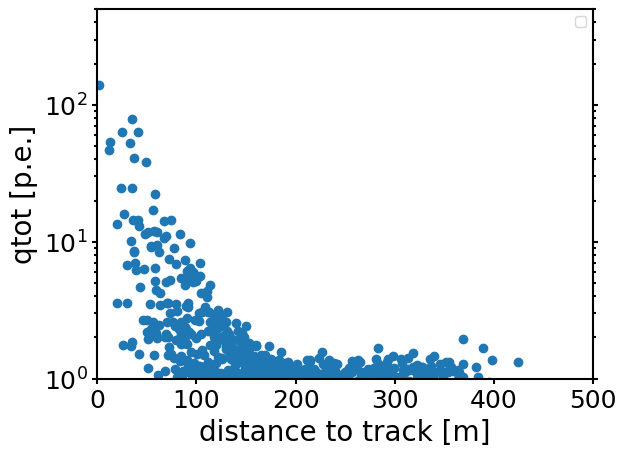

In [567]:
qtots = []
for dom_pos in positions_batch:
    qtots.append(qtot_dict[tuple(np.array(dom_pos))])

fig, ax = plt.subplots()
plt.scatter(closest_approach_dist, qtots)
plot_args = {'xlim':[0.0, 500],
                     'ylim':[0.0, 500],
                     'xlabel':'distance to track [m]',
                     'ylabel':'qtot [p.e.]'}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.yscale('log')
plt.ylim([1.0, 500])
plt.show()